<a href="https://colab.research.google.com/github/jsmazorra/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/Johan_Mazorra_LS_DS13_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import numpy as np
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [26]:
# Start by using a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and 
# the sale price was more than 100 thousand and less than 2 million.
df = df[df['BUILDING_CLASS_CATEGORY'].str.startswith('01 ONE FAMILY DWELLINGS')]
df = df[((df['SALE_PRICE']>100000) & (df['SALE_PRICE']<2000000))]

print(df.shape)
df.head()

(3151, 19)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,A9,550000,2019-01-01
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,1,A1,200000,2019-01-01
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,1,A1,810000,2019-01-02
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,1,A1,125000,2019-01-02
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,1,A5,620000,2019-01-02


In [20]:
df.describe()

,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.0,3.151000e+03
mean,6917.976515,75.981593,11027.219613,0.987623,0.015868,1.003491,3112.117423,1470.306887,1943.694700,1.0,6.285601e+05
std,3963.326705,161.089514,482.875284,0.113414,0.127499,0.171789,1790.055434,586.339200,26.676786,0.0,2.929904e+05
min,21.000000,1.000000,10030.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1890.000000,1.0,1.040000e+05
25%,4016.000000,21.000000,10461.000000,1.000000,0.000000,1.000000,2000.000000,1144.000000,1925.000000,1.0,4.475000e+05
50%,6301.000000,42.000000,11235.000000,1.000000,0.000000,1.000000,2542.000000,1360.000000,1938.000000,1.0,5.680000e+05
75%,10208.500000,69.000000,11413.000000,1.000000,0.000000,1.000000,4000.000000,1683.000000,1955.000000,1.0,7.600000e+05
max,16350.000000,2720.000000,11697.000000,2.000000,2.000000,3.000000,18906.000000,7875.000000,2018.000000,1.0,1.955000e+06


In [21]:
df.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,3151,3151,3151,3151,3151,3151,3151,3151
unique,5,6,1,2,13,3135,11,91
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,117-45 125TH STREET,A1,2019-01-31 00:00:00
freq,1580,2990,3151,3111,1185,2,1186,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-30 00:00:00


In [0]:
# Now, let's clean up and drop the columns with no data.
df = df.drop(['EASE-MENT', 'APARTMENT_NUMBER'], axis=1)

# Then let's make the column 'LAND_SQUARE_FEET' into integers.
df['LAND_SQUARE_FEET'] = pd.to_numeric(df['LAND_SQUARE_FEET'].str.replace(',',''))

In [8]:
# Let's set up the train and test split.

df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
print(df['SALE_DATE'].dtype)
df.head(1)

datetime64[ns]


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,A9,550000,2019-01-01


In [27]:
# Let's check if it changed.
df.dtypes

BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                           int64
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE                         datetime64[ns]
dtype: object

In [9]:
# Now, let's split the data.
train = df[df['SALE_DATE']<pd.to_datetime('2019-04-01')]
test = df[df['SALE_DATE']>=pd.to_datetime('2019-04-01')]

print(train['SALE_DATE'].dt.month.value_counts(),'\n')
print(test['SALE_DATE'].dt.month.value_counts())

1    947
3    799
2    761
Name: SALE_DATE, dtype: int64 

4    644
Name: SALE_DATE, dtype: int64


In [10]:
# Now, let's do the hot coding.
train.describe(include='object')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,BUILDING_CLASS_AT_TIME_OF_SALE
count,2507,2507,2507,2507,2507,2507,2507
unique,5,6,1,2,13,2497,11
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,216-29 114TH ROAD,A1
freq,1204,2382,2507,2476,919,2,919


In [0]:
target = 'SALE_PRICE'
high_cardinality = ['BUILDING_CLASS_CATEGORY','BUILDING_CLASS_AT_PRESENT','ADDRESS','BUILDING_CLASS_AT_TIME_OF_SALE','SALE_DATE']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)

In [12]:
X_train.head(5)

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,1,0,0,0,0,1,0,0,0,0,0,1,0,5495,801,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1
61,0,1,0,0,0,1,0,0,0,0,0,1,0,7918,72,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,1
78,0,0,1,0,0,1,0,0,0,0,0,1,0,4210,19,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,1
108,1,0,0,0,0,1,0,0,0,0,0,1,0,5212,69,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,1
111,1,0,0,0,0,1,0,0,0,0,0,1,0,7930,121,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,1


In [13]:
X_test = encoder.transform(X_test)

X_test.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
18235,0,0,1,0,0,1,0,0,0,0,0,1,0,5913,878,10471.0,1.0,0.0,1.0,5000,2272.0,1930.0,1
18239,0,0,1,0,0,1,0,0,0,0,0,1,0,5488,48,10465.0,1.0,0.0,1.0,2500,720.0,1935.0,1
18244,1,0,0,0,0,1,0,0,0,0,0,1,0,5936,31,11209.0,1.0,0.0,1.0,2880,2210.0,1925.0,1
18280,1,0,0,0,0,1,0,0,0,0,0,1,0,7813,24,11210.0,1.0,0.0,1.0,1305,1520.0,1915.0,1
18285,1,0,0,0,0,1,0,0,0,0,0,1,0,8831,160,11229.0,1.0,0.0,1.0,1800,840.0,1925.0,1


In [14]:
print(X_train.shape, X_test.shape)

(2507, 23) (644, 23)


In [15]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=15)

X_train_selected = selector.fit_transform(X_train, y_train)

# Let's get rid of the unnecessary warnings using a code provided in the channel.
import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [16]:
selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Selected Features:')
for x in selected_names:
  print(x)

print('\nUnselected Features:')
for x in unselected_names:
  print(x)

Selected Features:
BOROUGH_3
BOROUGH_4
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
BLOCK
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
LAND_SQUARE_FEET
GROSS_SQUARE_FEET

Unselected Features:
BOROUGH_1
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_ASTORIA
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
LOT
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE


In [30]:
# Next, let's check the mean absolute errors for the features.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
  print(f'{k} Features Used:')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

1 Features Used:
Test Mean Absolute Error: $183,641 

2 Features Used:
Test Mean Absolute Error: $179,555 

3 Features Used:
Test Mean Absolute Error: $170,782 

4 Features Used:
Test Mean Absolute Error: $169,937 

5 Features Used:
Test Mean Absolute Error: $168,235 

6 Features Used:
Test Mean Absolute Error: $168,339 

7 Features Used:
Test Mean Absolute Error: $167,966 

8 Features Used:
Test Mean Absolute Error: $165,030 

9 Features Used:
Test Mean Absolute Error: $165,654 

10 Features Used:
Test Mean Absolute Error: $165,077 

11 Features Used:
Test Mean Absolute Error: $155,288 

12 Features Used:
Test Mean Absolute Error: $156,684 

13 Features Used:
Test Mean Absolute Error: $154,811 

14 Features Used:
Test Mean Absolute Error: $154,835 

15 Features Used:
Test Mean Absolute Error: $154,835 

16 Features Used:
Test Mean Absolute Error: $154,588 

17 Features Used:
Test Mean Absolute Error: $154,482 

18 Features Used:
Test Mean Absolute Error: $155,279 

19 Features Used:
T

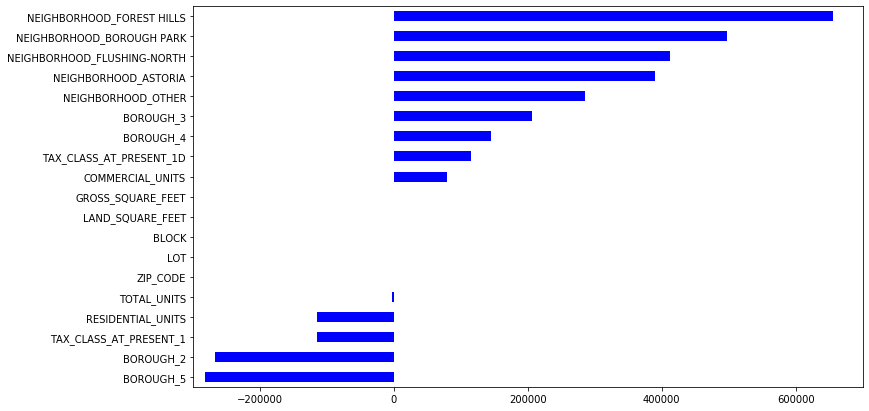

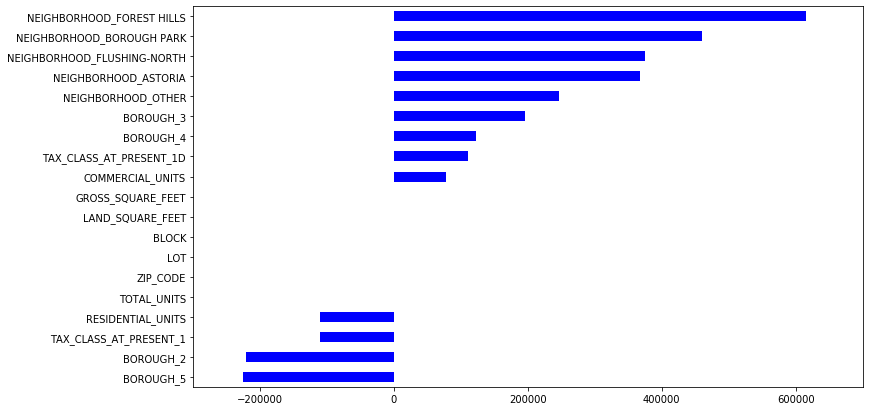

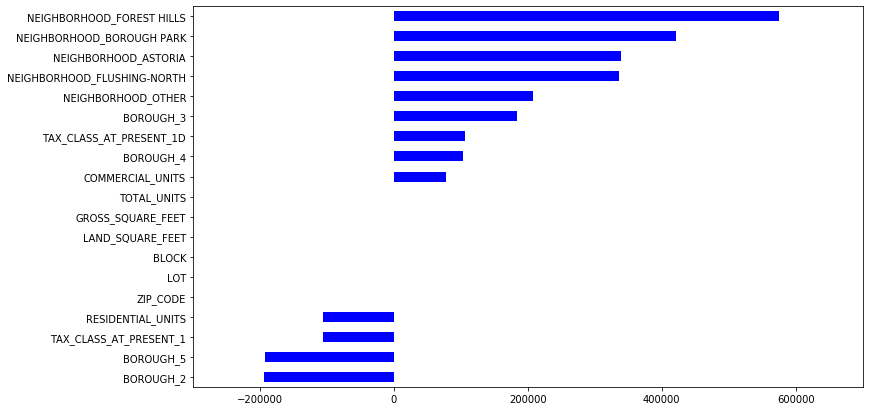

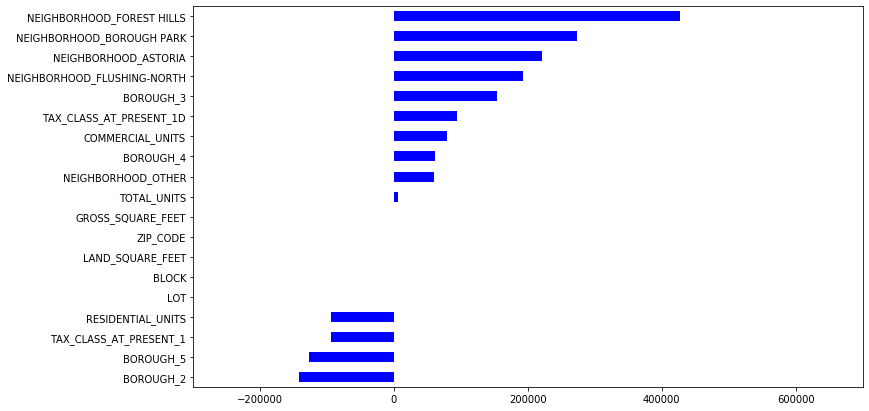

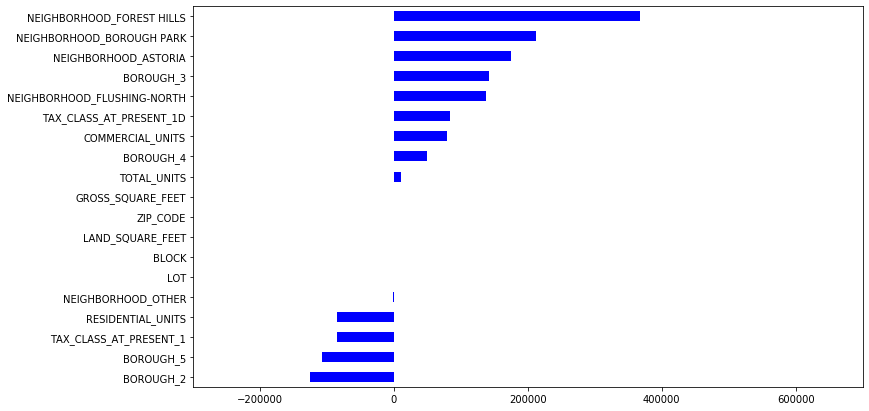

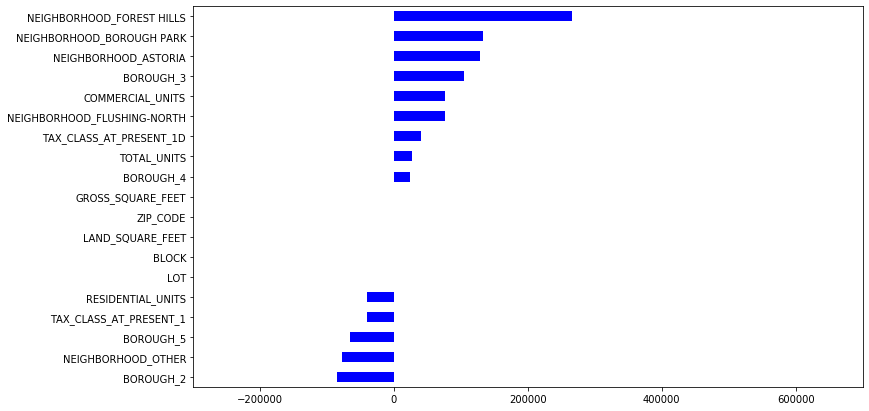

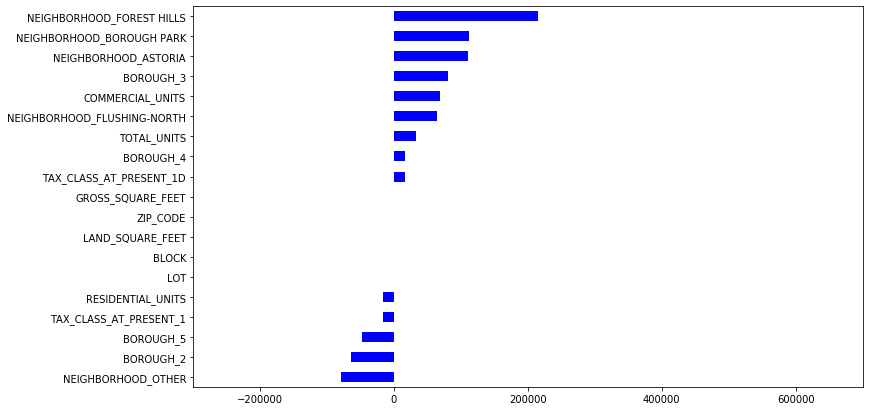

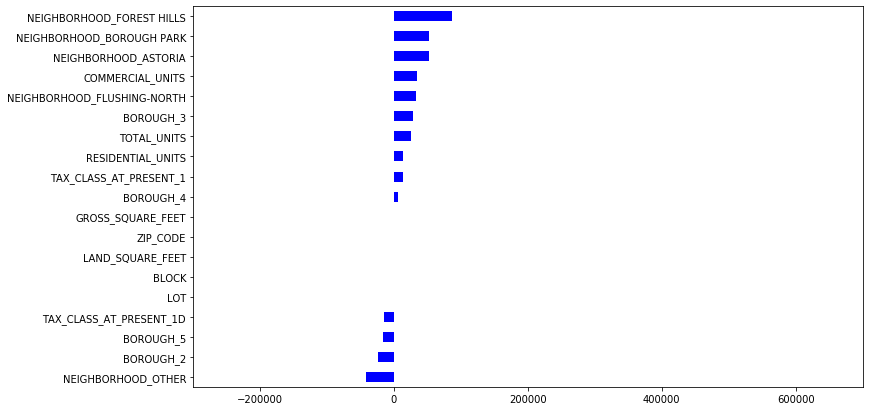

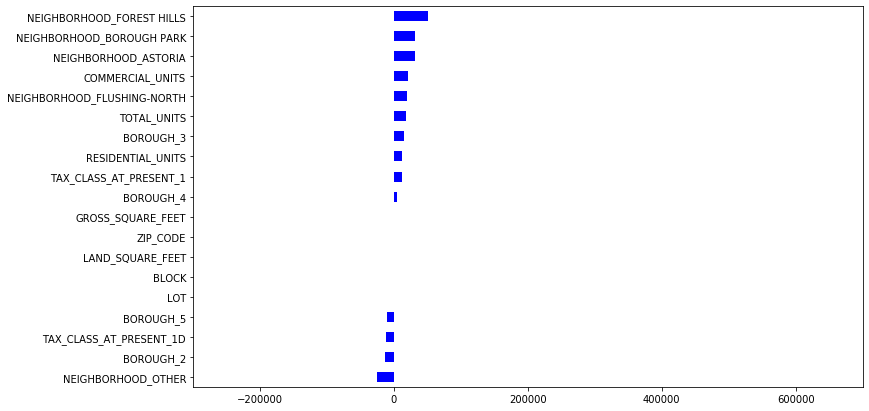

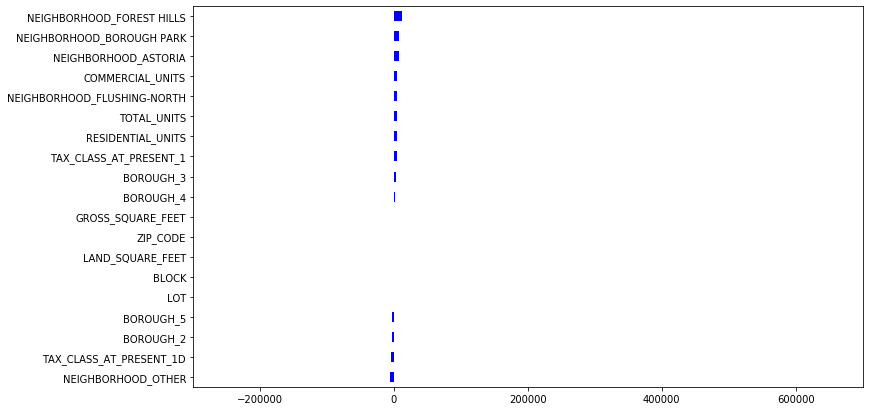

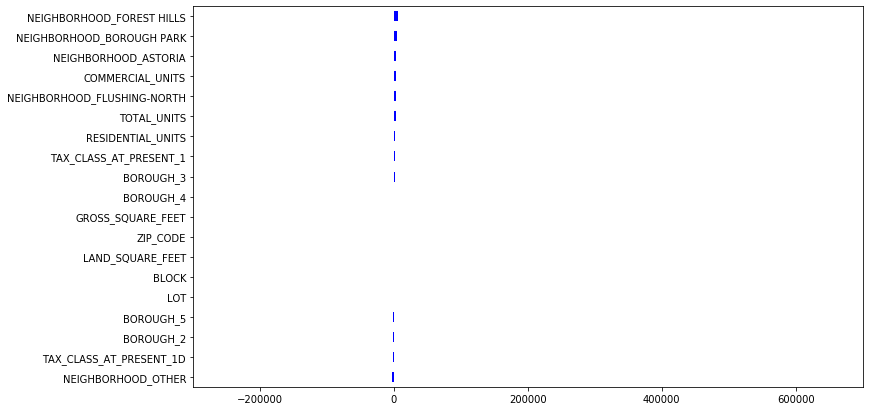

In [29]:
# Finally, let's get a visualization of the mean absolute errors.
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from IPython.display import display, HTML
%matplotlib inline

selector = SelectKBest(score_func=f_regression, k=19)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

for alpha in [.001, .005, .01, .05, .1, .5, 1, 5, 10, 50, 100]:
  display(HTML(f'Ridge Regression with alpha: {alpha}'))
  model = Ridge(alpha=alpha, normalize=True)
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)

  mae = mean_absolute_error(y_test, y_pred)
  display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))

  coefs = pd.Series(model.coef_, X_train.columns[selector.get_support()])
  plt.figure(figsize=(12,7))
  coefs.sort_values().plot.barh(color='blue')
  plt.xlim(-300000,700000)
  plt.show()